In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def linear_func(x, m, b):
    return m*x + b

In [5]:
# convert to sigma0*sigmaj, pbcs


def get_sigma_1_point(i, Szs):
    n_exp = 1/2 - np.mean(Szs)
    
    return (-1)**i*(1/2 - Szs[i] - n_exp)

# with i == 0
def get_sigma_2_point(j, Szs, SzSzs):
    n_exp = 1/2 - np.mean(Szs)
    
    ninj = 1/4 - Szs[0]/2 - Szs[j]/2 + SzSzs[j]
    
    ni = 1/2 - Szs[0]
    nj = 1/2 - Szs[j]
    
    return (-1)**(0+j)*(ninj - ni*n_exp - nj*n_exp + n_exp**2)

# wrt i == 0
def get_ryd_2_point(j, Szs, SzSzs):
    
    ninj = 1/4 - Szs[0]/2 - Szs[j]/2 + SzSzs[j]
    
    ni = 1/2 - Szs[0]
    nj = 1/2 - Szs[j]
    
    return (-1)**(0+j)*(ninj)

# wrt i == 0
def get_ryd_conn_2_point(j, Szs, SzSzs):
    
    ninj = 1/4 - Szs[0]/2 - Szs[j]/2 + SzSzs[j]
    
    ni = 1/2 - Szs[0]
    nj = 1/2 - Szs[j]
    
    return (-1)**(0+j)*(ninj - ni*nj)

In [26]:
# initialize the rydberg model 
real_omega = 1.55 # MHz
L = 24
Omega = 1
U = 9/real_omega
Rb = U**(1/6) #1.32

chi_max = 64
cutoff = 8.01
delta_t = 0.1

# rabi ramp parameters
omega_ramp_time = 2*real_omega # (1/omega)
omega_ramp_end_idx = int(2*real_omega/delta_t)

# dilila parameters
gapinit = 3.384
gapcrit = 0.24 #0.9276 
gapfin = 1.95

dini = -5/real_omega
#dcrit [0.5, 0.9, 1.1, 1.5]

num_deltas = 5
dcrits = [0.4, 1.34, 1.54, 1.74, 2.4] #np.linspace(0.5, 1.5, 20)
dcrits = np.array(dcrits)/real_omega

dfin = 4.45/real_omega

pulselen = 6.5*real_omega

total_ramp_time = pulselen
total_evolution_time = total_ramp_time

num_ts = int(total_evolution_time/delta_t) + omega_ramp_end_idx

evals = np.zeros([num_deltas, num_ts], dtype=complex) # energy
svals = np.zeros([num_deltas, num_ts, L-1], dtype=complex) # entropy

sigma_1_points = np.zeros([num_deltas, num_ts], dtype=complex)
#sigma_2_points = np.zeros([num_deltas, num_ts, L//2-1], dtype=complex)
sigma_2_points = np.zeros([num_deltas, num_ts, L-1], dtype=complex)

sz_1_points = np.zeros([num_deltas, num_ts, L], dtype=complex)
sz_2_points = np.zeros([num_deltas, num_ts, L], dtype=complex)

for idx, dcrit in enumerate(dcrits):
    save_filename = '../results/ramp_rydberg_ring_L_%d_Omega_%.2f_Rb_%.2f_dini_%.3f_dcrit_%.3f_dfin_%.3f_T_%.3f_chi_%04d_cutoff%.2f.npz'%(L, Omega, Rb, dini, dcrit, dfin, pulselen, chi_max, cutoff)
        
    test = np.load(save_filename)
    
    evals[idx, :] = test['evals'] 
    svals[idx, :] = test['svals']

    sigma_1_points[idx, :] = test['sigma_1_points']

    sz_1_points[idx, :] = test['sz_1_points']
    sz_2_points[idx, :] = test['sz_2_points']
    
    for j in range(L-1):
        for t_idx in range(num_ts):
            sigma_2_points[idx, t_idx, j] = get_sigma_2_point(j, sz_1_points[idx, t_idx, :], sz_2_points[idx, t_idx, :])


In [29]:
total_evolution_time

10.075000000000001

In [25]:
np.shape(sigma_2_points)

(5, 131, 23)

In [17]:
sigma_corr.real

array([0.11834128, 0.07851031, 0.05702167, 0.04320758, 0.0362603 ,
       0.02706268, 0.02468323, 0.02047684])

In [18]:
res_pbc = curve_fit(linear_func, np.log(djs), np.log(sigma_corr.real))


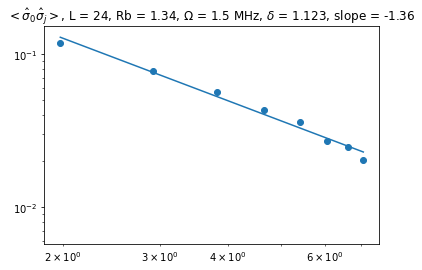

In [20]:
idx = 3

js = np.array(range(2, 10))
djs = L/np.pi*np.sin(np.pi/L*js)

sigma_corr = sigma_2_points[idx, -1, 2:10]
plt.scatter(djs, sigma_corr)


res_pbc = curve_fit(linear_func, np.log(djs), np.log(sigma_corr.real))
plt.loglog(djs, np.exp(linear_func(np.log(djs), res_pbc[0][0], res_pbc[0][1])))
plt.title('$<\hat \sigma_0 \hat \sigma_{j}>$, L = %d, Rb = %.2f, $\Omega$ = 1.5 MHz, $\delta$ = %.3f, slope = %.2f'%(L, Rb, dcrits[idx], res_pbc[0][0]))


plt.xscale('log')
plt.yscale('log')

In [33]:
idx = 3

js = np.array(range(2, 10))
djs = L/np.pi*np.sin(np.pi/L*js)

sigma_corr = sigma_2_points[idx, 60:80, 2:10]


20

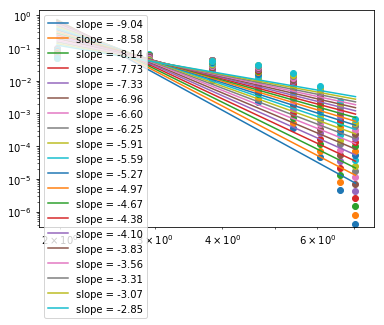

In [38]:
for i in range(len(sigma_corr)):
    plt.scatter(djs, sigma_corr[i])


    res_pbc = curve_fit(linear_func, np.log(djs), np.log(sigma_corr[i].real))
    plt.loglog(djs, np.exp(linear_func(np.log(djs), res_pbc[0][0], res_pbc[0][1])),label = str('slope = %.2f'%res_pbc[0][0]))
  #  plt.title('$<\hat \sigma_0 \hat \sigma_{j}>$, L = %d, Rb = %.2f, $\Omega$ = 1.5 MHz, $\delta$ = %.3f, slope = %.2f'%(L, Rb, dcrits[idx], res_pbc[0][0]))

plt.legend()
plt.xscale('log')
plt.yscale('log')

[0.58666582 0.98725006 1.1473754  1.0861757  0.29691386]


Text(0.5, 0, '$\\delta$ (MHz)')

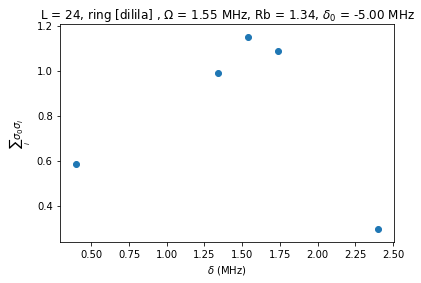

In [21]:
    
plt.scatter(dcrits*real_omega, np.sum(sigma_2_points[:, -1, 1:], axis=1))
print(np.real(np.sum(sigma_2_points[:, -1, 1:], axis=1)))
plt.title('L = %d, ring [dilila] , $\Omega$ = %.2f MHz, Rb = %.2f, $\delta_0$ = %.2f MHz'%(L, real_omega, Rb, 
                                                                                                                 dini*real_omega,
                                                                                                                ))                                                                                                                
plt.ylabel('$\sum_{i} \sigma_0\sigma_i$')
plt.xlabel('$\delta$ (MHz)')

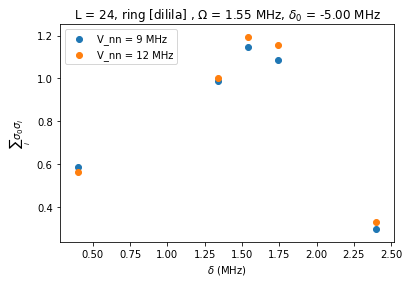

In [22]:
    
plt.scatter(dcrits*real_omega, [0.58666582, 0.98725006, 1.1473754,  1.0861757,  0.29691386])
plt.scatter(dcrits*real_omega, [0.56300143, 1.00375753, 1.19311649, 1.15493761, 0.33099176])

plt.title('L = %d, ring [dilila] , $\Omega$ = %.2f MHz, $\delta_0$ = %.2f MHz'%(L, real_omega, dini*real_omega))
                                                                                                                                                                                                                              
plt.ylabel('$\sum_{i} \sigma_0\sigma_i$')
plt.xlabel('$\delta$ (MHz)')
plt.legend(['V_nn = 9 MHz', 'V_nn = 12 MHz'])


